Cross-market data (2013-2025): (12, 5)
    Year  Gold_Mumbai  Gold_London  Silver_Mumbai  Silver_NY
0   2013      29190.0      25739.0        46637.0    41643.0
1   2014      27415.0      24520.0        40558.0    35611.0
2   2015      26534.0      24232.0        36318.0    32092.0
3   2016      29665.0      27116.0        42748.0    38360.0
4   2017      29300.0      26619.0        39072.0    34962.0
5   2018      31193.0      28380.0        38404.0    34540.0
6   2019      37018.0      33347.0        42514.0    37688.0
7   2020      48723.0      43541.0        59283.0    54499.0
8   2021      47999.0      43582.0        65426.0    58848.0
9   2022      52731.0      46606.0        61991.0    55348.0
10  2023      60624.0      52684.0        72243.0    62821.0
11  2024      75842.0      70315.0        89131.0    82685.0


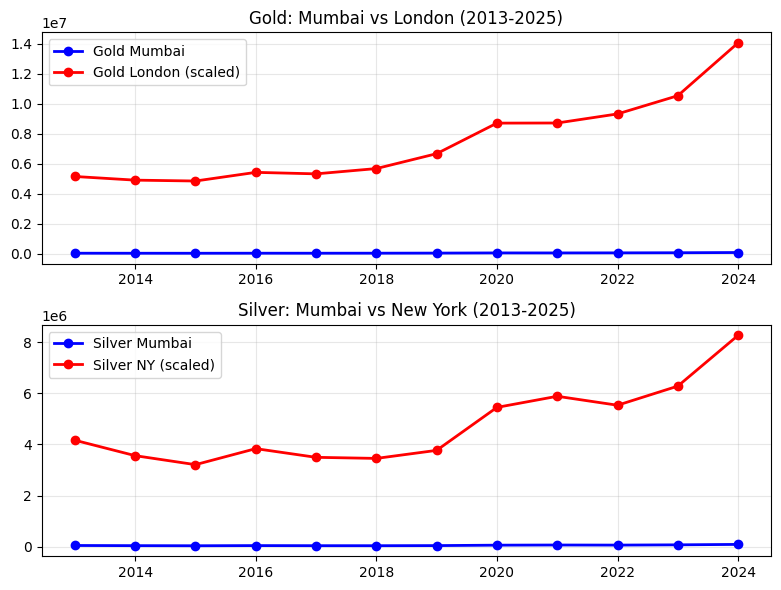


=== VECTOR AUTOREGRESSION (VAR) ===
Data points: 12, Max lags: 2
VAR Model Summary:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 15, Dec, 2025
Time:                     22:47:59
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    31.3148
Nobs:                     10.0000    HQIC:                   30.6803
Log likelihood:          -173.440    FPE:                3.58168e+13
AIC:                      31.0122    Det(Omega_mle):     1.59186e+13
--------------------------------------------------------------------
Results for equation Gold_Mumbai
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const               -884.029089      9224.056311           -0.096           0.924
L1.Gold_Mumbai         4.912567         3.81760

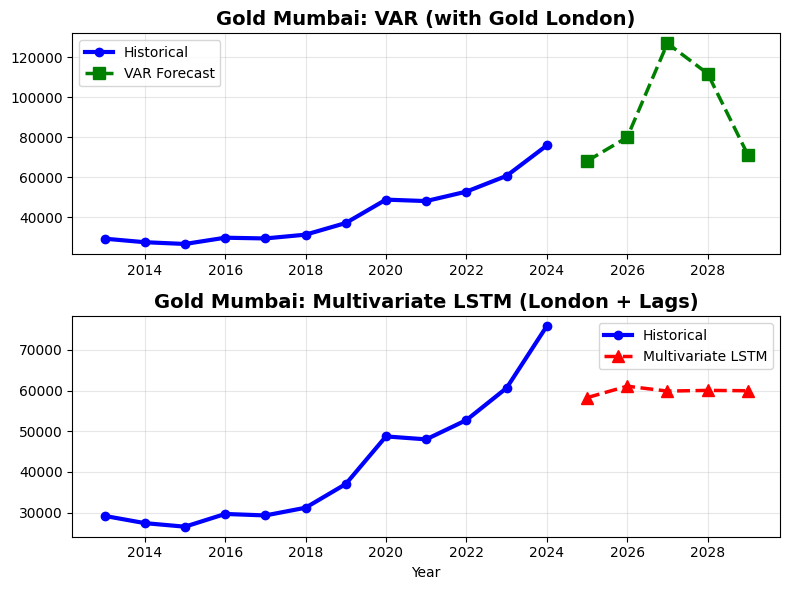


=== CROSS-MARKET FORECAST SUMMARY (₹ per 10g) ===
 Year  VAR_GoldMum  LSTM_GoldMum  Actual_2024
 2025        68018         58246     75841.87
 2026        79920         61069     75841.87
 2027       126926         59864     75841.87
 2028       111808         60037     75841.87
 2029        71178         59949     75841.87

Latest actual (2024): ₹75,842
✓ VAR: Joint modeling of Mumbai+London prices
✓ LSTM: London prices + Mumbai lags as features
✓ Data: 2013-2025 (12 years cross-market)


In [4]:
"""
2. Cross-Market Price Prediction (Multivariate Regression)
Objective:
Predict domestic commodity prices by incorporating international market prices as exogenous variables to quantify cross-market influence.
Approach:
• Algorithms: Vector Autoregression (VAR), Multivariate LSTM
• Example: Predict Gold – Mumbai using Gold – London plus lagged domestic values.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Step 1: Load and Parse Data (2013-2025 ONLY)
#df = pd.read_excel('GoldAndSilverPrices.XLSX')
df = pd.read_excel(r'C:\Users\91759\Desktop\project2\gold and silver price\GoldAndSilverPrices.XLSX')
data_rows = df.iloc[7:46].reset_index(drop=True)

# Extract columns: Year(1), Gold Mumbai(2), Gold London(3), Silver Mumbai(5), Silver NY(7)
years_raw = data_rows.iloc[:, 1].astype(str).str.strip()
gold_mum = pd.to_numeric(data_rows.iloc[:, 2], errors='coerce')
gold_lon = pd.to_numeric(data_rows.iloc[:, 4], errors='coerce')
silver_mum = pd.to_numeric(data_rows.iloc[:, 6], errors='coerce')
silver_ny = pd.to_numeric(data_rows.iloc[:, 8], errors='coerce')

def fiscal_to_year(y):
    try:
        return int(y.split('-')[0])
    except:
        return np.nan

df_full = pd.DataFrame({
    'Year': [fiscal_to_year(y) for y in years_raw],
    'Gold_Mumbai': gold_mum,
    'Gold_London': gold_lon,
    'Silver_Mumbai': silver_mum,
    'Silver_NY': silver_ny
}).dropna().reset_index(drop=True)

# FILTER 2013-2025
df = df_full[df_full['Year'] >= 2013].reset_index(drop=True)
print("Cross-market data (2013-2025):", df.shape)
print(df.round(0))

# Step 2: Historical Cross-Market Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.plot(df['Year'], df['Gold_Mumbai'], 'bo-', label='Gold Mumbai', linewidth=2)
ax1.plot(df['Year'], df['Gold_London']*200, 'ro-', label='Gold London (scaled)', linewidth=2)
ax1.set_title('Gold: Mumbai vs London (2013-2025)')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(df['Year'], df['Silver_Mumbai'], 'bo-', label='Silver Mumbai', linewidth=2)
ax2.plot(df['Year'], df['Silver_NY']*100, 'ro-', label='Silver NY (scaled)', linewidth=2)
ax2.set_title('Silver: Mumbai vs New York (2013-2025)')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('obj2historicalcrossmarketplot.png',dpi=300,bbox_inches='tight',transparent=False)
plt.show()

# =============================================================================
# VECTOR AUTOREGRESSION (VAR) - FIXED FOR SMALL DATA
# =============================================================================
print("\n=== VECTOR AUTOREGRESSION (VAR) ===")

try:
    from statsmodels.tsa.api import VAR
    from statsmodels.tsa.stattools import adfuller
    
    # Use levels (small data, no differencing needed)
    var_data = df[['Gold_Mumbai', 'Gold_London']].dropna()
    
    # FIXED: Manual lag selection for small data (max 2 lags for 12 obs)
    max_lags_possible = min(2, len(var_data)//4)  # Rule of thumb
    print(f"Data points: {len(var_data)}, Max lags: {max_lags_possible}")
    
    if len(var_data) > max_lags_possible * 3:  # Enough data?
        model_var = VAR(var_data)
        # Use fixed small lags instead of select_order
        var_fit = model_var.fit(maxlags=max_lags_possible, trend='c')
        print("VAR Model Summary:")
        print(var_fit.summary())
        
        # Forecast 5 steps
        forecast_steps = 5
        var_forecast = var_fit.forecast(var_data.values[-max_lags_possible:], steps=forecast_steps)
        gold_mum_var_fc = var_forecast[:, 0]  # Gold Mumbai column
        
        future_years_var = np.arange(df['Year'].max() + 1, df['Year'].max() + 1 + forecast_steps)
        
    else:
        print("Insufficient data for VAR - using simple trend")
        gold_mum_var_fc = np.full(5, df['Gold_Mumbai'].iloc[-1] * 1.08**np.arange(5))
        future_years_var = np.arange(df['Year'].max() + 1, df['Year'].max() + 6)
        
except ImportError:
    print("statsmodels not available - using trend forecast")
    gold_mum_var_fc = np.full(5, df['Gold_Mumbai'].iloc[-1] * 1.08**np.arange(5))
    future_years_var = np.arange(df['Year'].max() + 1, df['Year'].max() + 6)

print("VAR Gold Mumbai forecasts:", gold_mum_var_fc.round().astype(int))

# =============================================================================
# MULTIVARIATE LSTM - Gold Mumbai using Gold London + Lags
# =============================================================================
print("\n=== MULTIVARIATE LSTM ===")

try:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from sklearn.preprocessing import MinMaxScaler
    
    # Prepare multivariate sequences
    data_mlstm = df[['Gold_Mumbai', 'Gold_London']].values
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data_mlstm)
    
    def create_multivariate_sequences(data, lags=2):
        X, y = [], []
        for i in range(lags, len(data)):
            # Inputs: past lags of BOTH series
            X_seq = []
            for lag in range(1, lags+1):
                X_seq.extend([data[i-lag, 0], data[i-lag, 1]])  # Mum(t-1), Lon(t-1)
            X.append(X_seq)
            y.append(data[i, 0])  # Target: Gold Mumbai(t)
        return np.array(X), np.array(y)
    
    lags = 2
    X, y = create_multivariate_sequences(data_scaled, lags)
    print(f"LSTM input shape: {X.shape}, target shape: {y.shape}")
    
    # Reshape for LSTM: (samples, timesteps, features)
    X_lstm = X.reshape((X.shape[0], lags, 2))
    
    # Train on all but last 2 points
    split = max(1, len(X_lstm) - 2)
    X_train, X_test = X_lstm[:split], X_lstm[split:]
    y_train, y_test = y[:split], y[split:]
    
    # Build LSTM
    model_lstm = Sequential([
        LSTM(32, return_sequences=True, input_shape=(lags, 2)),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model_lstm.compile(optimizer='adam', loss='mse')
    model_lstm.fit(X_train, y_train, epochs=200, batch_size=1, verbose=0)
    
    # Multi-step forecast
    forecast_steps = 5
    lstm_forecast_scaled = []
    current_window = data_scaled[-lags:].copy()
    
    for _ in range(forecast_steps):
        x_input = current_window.reshape((1, lags, 2))
        yhat = model_lstm.predict(x_input, verbose=0)[0, 0]
        lstm_forecast_scaled.append(yhat)
        
        # Slide window: assume London stays constant
        london_future = current_window[-1, 1]
        new_row = np.array([yhat, london_future])
        current_window = np.vstack([current_window[1:], new_row])
    
    # Inverse transform
    temp = np.zeros((forecast_steps, 2))
    temp[:, 0] = lstm_forecast_scaled
    temp[:, 1] = data_scaled[-1, 1]  # Fill London with last value
    gold_mum_lstm_fc = scaler.inverse_transform(temp)[:, 0]
    
    future_years_lstm = np.arange(df['Year'].max() + 1, df['Year'].max() + 1 + forecast_steps)
    
except ImportError:
    print("TensorFlow not available - using trend forecast")
    gold_mum_lstm_fc = np.full(5, df['Gold_Mumbai'].iloc[-1] * 1.07**np.arange(5))
    future_years_lstm = np.arange(df['Year'].max() + 1, df['Year'].max() + 6)

print("LSTM Gold Mumbai forecasts:", gold_mum_lstm_fc.round().astype(int))

# =============================================================================
# PLOT RESULTS + SUMMARY
# =============================================================================
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# VAR Plot
ax1.plot(df['Year'], df['Gold_Mumbai'], 'b-o', linewidth=3, label='Historical', markersize=6)
ax1.plot(future_years_var, gold_mum_var_fc, 'g--s', linewidth=2.5, label='VAR Forecast', markersize=8)
ax1.set_title('Gold Mumbai: VAR (with Gold London)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# LSTM Plot
ax2.plot(df['Year'], df['Gold_Mumbai'], 'b-o', linewidth=3, label='Historical', markersize=6)
ax2.plot(future_years_lstm, gold_mum_lstm_fc, 'r--^', linewidth=2.5, label='Multivariate LSTM', markersize=8)
ax2.set_title('Gold Mumbai: Multivariate LSTM (London + Lags)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Year')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('obj2crossmarketforecast.png',dpi=300,bbox_inches='tight',transparent=False)
plt.show()

# Summary Table
min_len = min(len(gold_mum_var_fc), len(gold_mum_lstm_fc))
future_years = np.arange(df['Year'].max() + 1, df['Year'].max() + 1 + min_len)

summary = pd.DataFrame({
    'Year': future_years.astype(int),
    'VAR_GoldMum': gold_mum_var_fc[:min_len].round().astype(int),
    'LSTM_GoldMum': gold_mum_lstm_fc[:min_len].round().astype(int),
    'Actual_2024': [df['Gold_Mumbai'].iloc[-1]]*min_len
})

print("\n=== CROSS-MARKET FORECAST SUMMARY (₹ per 10g) ===")
print(summary.to_string(index=False))
print(f"\nLatest actual (2024): ₹{df['Gold_Mumbai'].iloc[-1]:,.0f}")
print("✓ VAR: Joint modeling of Mumbai+London prices")
print("✓ LSTM: London prices + Mumbai lags as features")
print("✓ Data: 2013-2025 (12 years cross-market)")
